# 初始化

In [382]:
import numpy as np
import torch
import os
import sys
import math
import matplotlib.pyplot as plt

from my_utility import compute_Fourier_modes, compute_Fourier_bases

N = 1000
k = 4
t = np.linspace(0,2*np.pi,N, endpoint=False)
x = torch.from_numpy(np.array([k*np.cos(t), np.sin(t)]).T).unsqueeze(0)  #1,n,2
w = torch.from_numpy(np.linalg.norm(np.array([-k*np.sin(t), np.cos(t)]).T, axis = -1, keepdims = True)).unsqueeze(0).unsqueeze(-1)   #1,n,1,1
w = w/N

norm0 = np.array([np.cos(t), k*np.sin(t)]).T  # n,2
nx = torch.from_numpy(norm0/(np.linalg.norm(norm0, axis = -1, keepdims = True)) ).unsqueeze(0) #1,N,2
# nx = x/np.linalg.norm(x, axis = -1, keepdims = True)

def f(x):
    b,n,c = x.shape
    
    x, y = x[:,:,0], x[:,:,1]
    # fx = torch.sin(2*torch.pi*x)
    # fx = x + torch.exp(y)
    fx = torch.abs(torch.sin((x**3 + y**3))) + torch.exp(y**3)
    # fx = torch.exp(torch.sin(x**2 + y**2) + torch.abs(x) + torch.abs(y))
    # fx = torch.exp(x**4 + y**4)/(1 + torch.log(1 + x**2 + y**2))
    # fx = torch.ones_like(x)

    return fx.reshape(b,n)

k_max = 80
L = [4*k,4]
# sigma = 0.1*k
# sigma = 0.02*k
sigma = 0.1


# 定义一些通用函数

In [383]:
def plot_projection(x_x, x_y, y_true, y_proj, figsize = (15,4)):
    '''
    x_x: (n,)
    x_y: (n,)
    y_true: (n,)
    y_proj: (n,)
    coffe_list: [c_coffe, s_coffe, 0_coffe]
    '''
    fig, axs = plt.subplots(1, 3, figsize=figsize)
    sc1 = axs[0].scatter(x_x, x_y,  
                c = y_true,
                cmap="viridis", 
                marker="o",)
    axs[0].set_title("y")
    axs[0].set_aspect('equal')
    fig.colorbar(sc1, ax=axs[0])


    sc2 = axs[1].scatter(x_x, x_y,  
                c = y_proj,
                cmap="viridis", 
                marker="o",)
    axs[1].set_title("y_out")
    axs[1].set_aspect('equal')
    fig.colorbar(sc2, ax=axs[1])

    sc3 = axs[2].scatter(x_x, x_y,  
                c = y_proj - y_true,
                cmap="viridis", 
                marker="o",)
    axs[2].set_title("error")
    axs[2].set_aspect('equal')
    fig.colorbar(sc3, ax=axs[2])

    plt.show()
    
def plot_coffe(coffe_list, figsize = (15,4)):
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    axs[0].plot(
        [i for i in range(len(coffe_list[0]))], 
        coffe_list[0], 
        marker='*', 
        linestyle="-",
        linewidth=1,
        color='blue',          # 线条颜色
        markerfacecolor='red', # 标记填充色
        markeredgecolor='red', # 标记边框色
        markersize=5,          # 标记尺寸（单位：磅）
        label="c"
    )
    axs[1].plot(
        [i for i in range(len(coffe_list[1]))], 
        coffe_list[1], 
        marker='*', 
        linestyle="-",
        linewidth=1,
        color='blue',          # 线条颜色
        markerfacecolor='red', # 标记填充色
        markeredgecolor='red', # 标记边框色
        markersize=5,          # 标记尺寸（单位：磅）
        label="s"
    )

    axs[0].grid(True)
    axs[0].set_title('cos')
    axs[1].grid(True)
    axs[1].set_title('sin')
    print('zero_hat: ',coffe_list[2])
    plt.show()

# 直接计算系数

loss:  0.3135598599077057


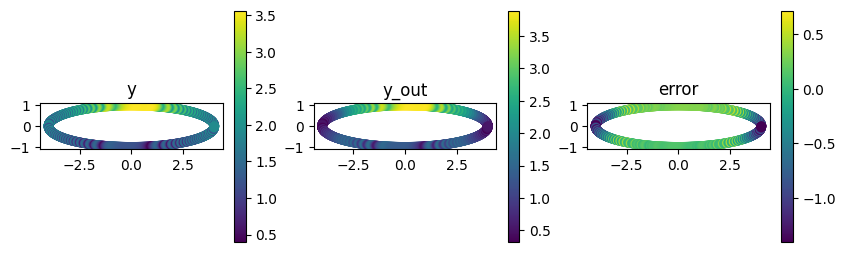

zero_hat:  5.170315585843552


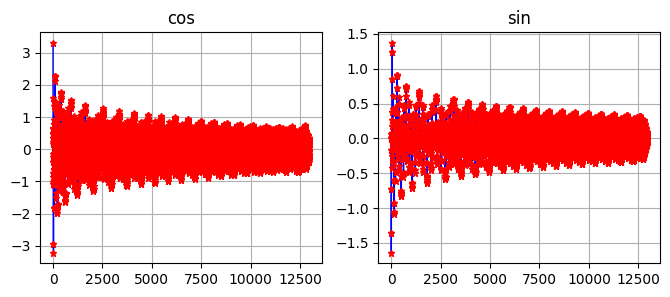

In [384]:

def decomposition_directly(x,y,w, k_max, L):
    '''
    x:  1, N, 2 
    y:  1, N 
    w:  1, N , 1 ,1

    return: 1, N 
    
    '''
    modes = torch.tensor(compute_Fourier_modes(2, [k_max,k_max], L))  # nmodes, 2, 1
    bases_c,  bases_s,  bases_0  = compute_Fourier_bases(x, modes)  # (1, n, nmodes, 1) , (1, n, nmodes, 1), (1, n, 1, 1)
    wbases_c,  wbases_s,  wbases_0 = bases_c*w,  bases_s*w,  bases_0*w

    f_c_hat =  torch.einsum("bx,bxkw->bkw", y, wbases_c)
    f_s_hat = -torch.einsum("bx,bxkw->bkw", y, wbases_s)
    f_0_hat =  torch.einsum("bx,bxkw->bkw", y, wbases_0)

    c_hat = [c.item() for c in f_c_hat[0,:,0]]
    s_hat = [s.item() for s in f_s_hat[0,:,0]]
    zero_hat = f_0_hat.item()
    # print(f_c_hat)
    # print(f_s_hat)
    # print(f_0_hat)
    y_out = torch.einsum("bkw,bxkw->bx", f_0_hat, bases_0)  + 2*torch.einsum("bkw,bxkw->bx", f_c_hat, bases_c) -  2*torch.einsum("bkw,bxkw->bx", f_s_hat, bases_s) 

    return y_out, [c_hat,s_hat,zero_hat]

y = f(x)
y_out, coffe_list = decomposition_directly(x, y, w, k_max, L)

# argmin_c ||y - c*y_out|| = <y, y_out>/||y_out||^2
coffe = torch.dot(y[0], y_out[0])/torch.norm(y_out[0])**2
y_out = y_out * coffe
print('loss: ', (torch.norm(y - y_out)/torch.norm(y)).item())


plot_projection(x[0,:,0], x[0,:,1], y[0,:], y_out[0,:], (10,3))
plot_coffe(coffe_list,(8,3))

# 单步NORMFIX

sigma = 0.1, k_max = 80, L = [16, 4]
loss:  0.10820910596431986


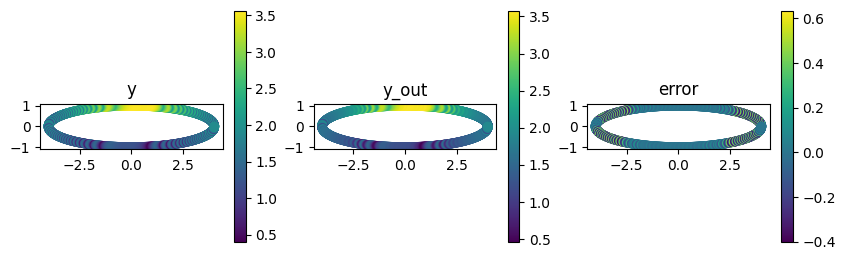

zero_hat:  [1.2960059236240793]


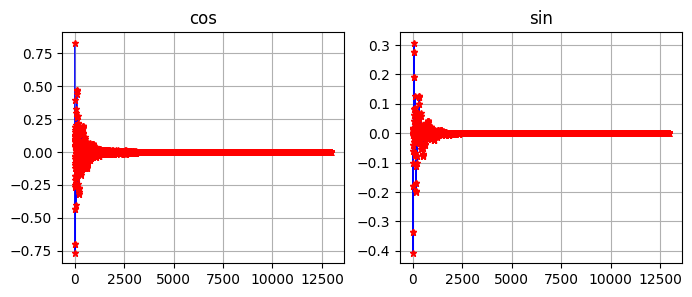

In [385]:
def normfix_onestep(x, y, nx, w, sigma, k_max, L):
    y_out_tube , coffe_list = decomposition_tube(x, y, nx, w, sigma, k_max, L)


    coffe = (torch.dot(y[0], y_out_tube[0])/(torch.norm(y_out_tube[0])**2) + 1e-5).item()
    # coffe = 1/(L[0]*L[1])
    # print('coffe', coffe)
    y_out_tube = y_out_tube * coffe

    
    return y_out_tube, coffe_list

def compute_correction_term(nx, modes, sigma):

    # temp : float[batch_size, nnodes, nmodes, nmeasures]
    temp  = torch.einsum("bxd,kdw->bxkw", nx, modes) 
    correction_nx = pow(2*np.pi*sigma**2, 1/2)*torch.exp(-sigma**2/2*temp**2)

    return correction_nx

def decomposition_tube(x, y, nx, w, sigma, k_max, L):


    modes = torch.tensor(compute_Fourier_modes(2, [k_max,k_max], L))  # nmodes, 2, 1
    bases_c,  bases_s,  bases_0  = compute_Fourier_bases(x, modes)  # (1, n, nmodes, 1) , (1, n, nmodes, 1), (1, n, 1, 1)

    wbases_c,  wbases_s,  wbases_0 = bases_c*w,  bases_s*w,  bases_0*w

    correction = compute_correction_term(nx, modes, sigma)
    # print(correction)
    wbases_c_cor = wbases_c * correction
    wbases_s_cor = wbases_s * correction
    # print(pow(2*torch.pi*sigma**2, 1/2))
    wbases_0 = wbases_0 * pow(2*torch.pi*sigma**2, 1/2)
    

    f_c_hat =  torch.einsum("bx,bxkw->bkw", y, wbases_c_cor)
    f_s_hat = -torch.einsum("bx,bxkw->bkw", y, wbases_s_cor)
    f_0_hat =  torch.einsum("bx,bxkw->bkw", y, wbases_0)

    c_hat = [c.item() for c in f_c_hat[0,:,0]]
    s_hat = [s.item() for s in f_s_hat[0,:,0]]
    zero_hat = [f_0_hat.item()]
    
    y_out = torch.einsum("bkw,bxkw->bx", f_0_hat, bases_0)  + 2*torch.einsum("bkw,bxkw->bx", f_c_hat, bases_c) -  2*torch.einsum("bkw,bxkw->bx", f_s_hat, bases_s) 

    return y_out, [c_hat,s_hat,zero_hat]


print(f'sigma = {sigma}, k_max = {k_max}, L = {L}')
y = f(x)

y_out_normfix, coffe_list = normfix_onestep(x, y, nx, w, sigma, k_max, L)

print('loss: ', (torch.norm(y - y_out_normfix)/torch.norm(y)).item())

plot_projection(x[0,:,0], x[0,:,1], y[0,:], y_out_normfix[0,:], (10,3))
plot_coffe(coffe_list, (8,3))

# 多步NORMFIX

sigma_list = [0.2, 0.1, 0.05], k_max_list = [80, 80, 80], L = [16, 4]
final loss:  0.09698062228941662


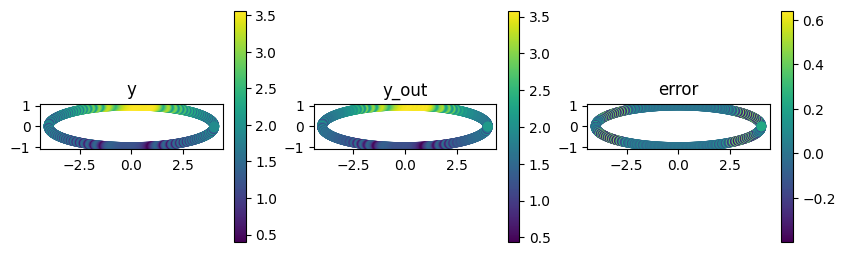

zero_hat:  [2.591709621243064]


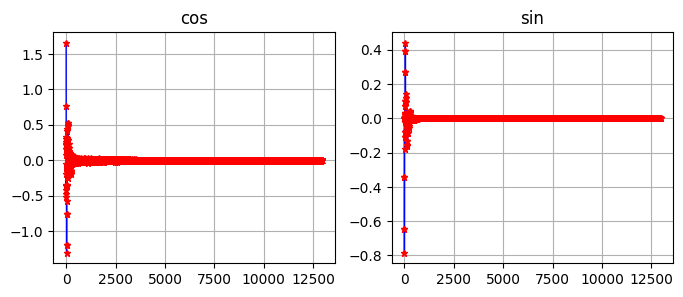

In [386]:
def normfix_twostep(x, y, nx, w, sigma1, sigma, k_max1, k_max, L):
    y_out_normfix1, coffe_list1 = normfix_onestep(x, y, nx, w, sigma1, k_max1, L)
    y_out_normfix2, coffe_list2 = normfix_onestep(x, y - y_out_normfix1, nx, w, sigma, k_max, L)

    y_normfix = y_out_normfix1 + y_out_normfix2
    
    coffe_list = [[c1 + c2 for (c1,c2) in zip(coffe_list1[i] + [0]*(len(coffe_list2[i]) -len(coffe_list1[i])),coffe_list2[i])] for i in range(3)]
    return y_normfix , coffe_list

def normfix_multistep(x, y, nx, w, sigma_list, k_max_list, L):
    for i,(sigma,k_max) in enumerate(zip(sigma_list, k_max_list)):
        if i==0:
            y_normfix, coffe_list = normfix_onestep(x, y, nx, w, sigma, k_max, L)
        else:
            y_normfix_new, coffe_list_new = normfix_onestep(x, y - y_normfix, nx, w, sigma, k_max, L)
            y_normfix = y_normfix + y_normfix_new

            len_add = len(coffe_list_new[0]) - len(coffe_list[0])
            coffe_list[0] = coffe_list[0] + [0]*len_add
            coffe_list[1] = coffe_list[1] + [0]*len_add
            coffe_list = [[c1 + c2 for (c1,c2) in zip(coffe_list[i] ,coffe_list_new[i])] for i in range(3)]
    
    return y_normfix , coffe_list


# y_out_normfix, coffe_list = normfix_twostep(x, y, nx, w, 5*sigma, sigma, 5, k_max, L)
# sigma_list = [i**2*sigma for i in range(1,3)]
# k_max_list = [k_max//i**2 for i in range(1,3)]
# sigma_list.reverse()
# k_max_list.reverse()

sigma_list = [2*sigma, sigma, sigma/2]
k_max_list = [k_max, k_max, k_max]

print(f'sigma_list = {sigma_list}, k_max_list = {k_max_list}, L = {L}')
y_normfix, coffe_list = normfix_multistep(x, y, nx, w, sigma_list, k_max_list, L)


print('final loss: ', (torch.norm(y - y_normfix)/torch.norm(y)).item())

plot_projection(x[0,:,0], x[0,:,1], y[0,:], y_normfix[0,:], (10,3))
plot_coffe(coffe_list, (8,3))

    



# 单步Padding图

sigma = 0.1, k_max = 80, L = [16, 4]
loss:  0.3570771763452791


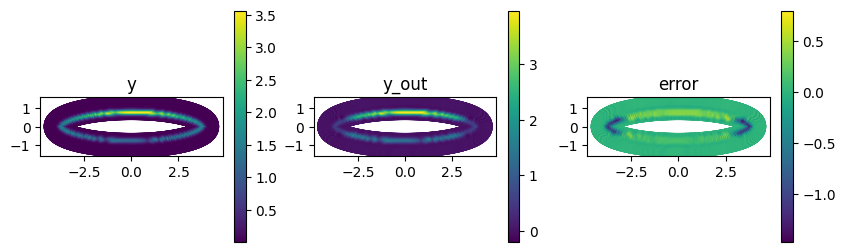

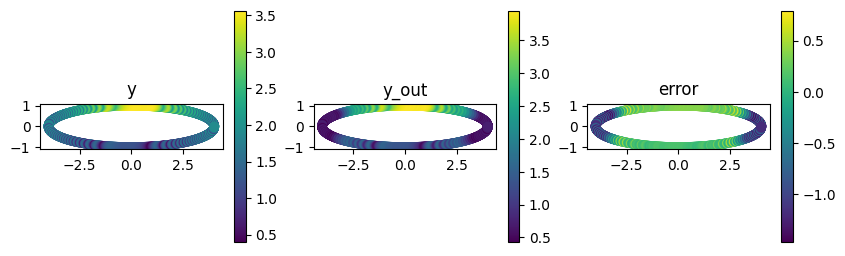

zero_hat:  1.2959876842046574


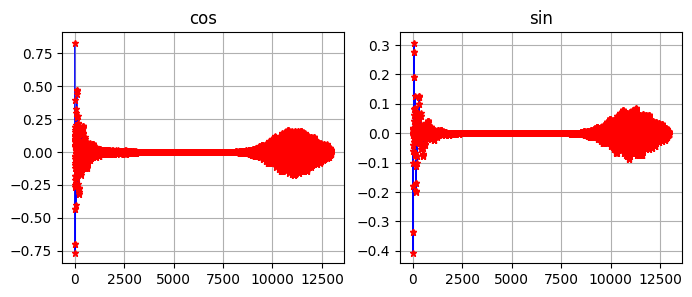

In [387]:
print(f'sigma = {sigma}, k_max = {k_max}, L = {L}')

def f_expend(x_in, sigma, r_list, y_re = None):
    '''
    x_in: num_r, N, n_dim
    r_list: num_r
    y_re: 1, N

    y: num_r, N, 1
    '''
    if y_re != None:
        y1 = y_re.repeat(len(r_list),1).unsqueeze(-1)
    else:
        y1 = f(x_in[7:8,:]).repeat(len(r_list),1).unsqueeze(-1)
    y2 = torch.exp(-1/(2*sigma**2)*(torch.from_numpy(r_list.reshape(-1,1,1)))**2)
    y = y1*y2
    return y

def padding(x, nx, w, sigma, y_re = None):
    r_list = np.linspace(-4*sigma, 4*sigma, 15)
    r_step = r_list[1] - r_list[0]
    x_expend = torch.from_numpy(np.array([x.squeeze().numpy() + r*nx.squeeze().numpy() for r in r_list]))
    # print(x_expend.shape)  # 15,n,2

    w_expend = np.array([w.squeeze().numpy()*r_step for _ in range(len(r_list))])
    w_expend = torch.from_numpy(w_expend).reshape(1,-1,1,1)  # 1,15*n,1,1
    y_expend = f_expend(x_expend, sigma, r_list, y_re)  # 15,n,1
    y_expend = y_expend.reshape(1,-1)  # 1,15*n
    x_expend = x_expend.reshape(1,-1,2)
    return x_expend, y_expend, w_expend


x_expend, y_expend, w_expend = padding(x, nx, w, sigma,)
y_out, coffe_list = decomposition_directly(x_expend, y_expend, w_expend, k_max, L)

x_re = x_expend[0,7*N:8*N,:].clone()
y_out_re = y_out[0,7*N:8*N].clone()
y_re = y_expend[0,7*N:8*N].clone()

coffe = torch.dot(y_re, y_out_re)/torch.norm(y_out_re)**2
y_out_re = y_out_re * coffe
y_out = y_out * coffe
print('loss: ', (torch.norm(y_re - y_out_re)/torch.norm(y_re)).item())

plot_projection(x_expend[0,:,0], x_expend[0,:,1], y_expend[0], y_out[0], (10,3))
plot_projection(x_re[:,0], x_re[:,1], y_re, y_out_re, (10,3))
plot_coffe(coffe_list, (8,3))

# 多步Padding图

sigma_list = [0.2, 0.1, 0.05], k_max_list = [80, 80, 80], L = [16, 4]
sigma = 0.2, k_max = 80, L = [16, 4]
loss:  0.3478470270596407


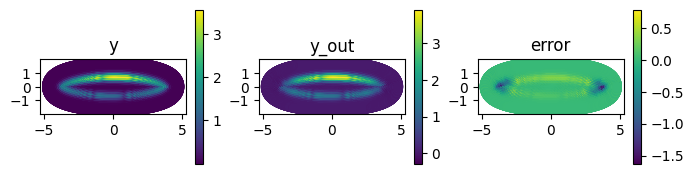

zero_hat:  2.5919753684093148


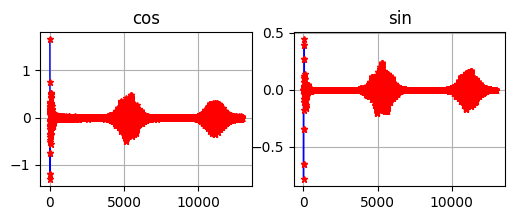

sigma = 0.1, k_max = 80, L = [16, 4]
loss:  0.9663842092329819


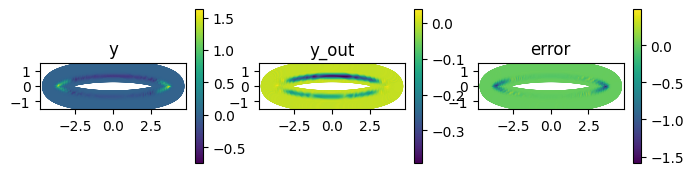

zero_hat:  -1.2054863373463642


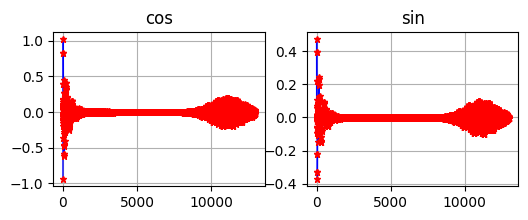

sigma = 0.05, k_max = 80, L = [16, 4]
loss:  0.3678994646934386


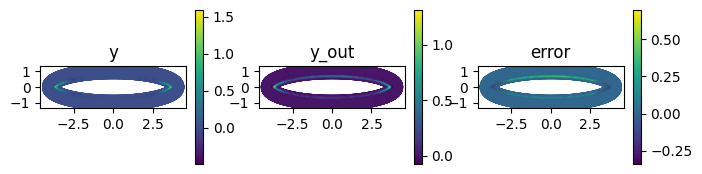

zero_hat:  0.1412367645055934


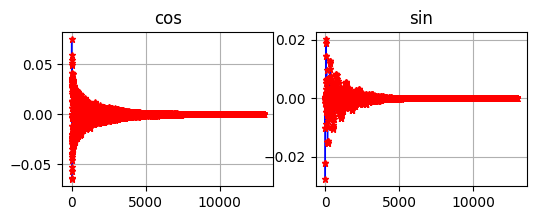

In [388]:
print(f'sigma_list = {sigma_list}, k_max_list = {k_max_list}, L = {L}')

for i, (sigma,k_max) in enumerate(zip(sigma_list,k_max_list)):  
    if i == 0:
        print(f'sigma = {sigma}, k_max = {k_max}, L = {L}')
        x_expend, y_expend, w_expend = padding(x, nx, w, sigma)
        y_out, coffe_list = decomposition_directly(x_expend, y_expend, w_expend, k_max, L)

        y_out_re = y_out[0:1,7*N:8*N].clone()
        y_re = y_expend[0:1,7*N:8*N].clone()
        coffe = torch.dot(y_re[0], y_out_re[0])/torch.norm(y_out_re[0])**2
        y_out_re = y_out_re * coffe
        y_out = y_out * coffe
        error_re = y_re - y_out_re
        print('loss: ', (torch.norm(error_re)/torch.norm(y_re)).item())
        plot_projection(x_expend[0,:,0], x_expend[0,:,1], y_expend[0], y_out[0],(8,2))
        plot_coffe(coffe_list,(6,2))
        
    else:
        print(f'sigma = {sigma}, k_max = {k_max}, L = {L}')
        x_expend, y_expend, w_expend = padding(x, nx, w, sigma, error_re)
        y_out, coffe_list = decomposition_directly(x_expend, y_expend - y_out, w_expend, k_max, L)
        y_out_re = y_out[0:1,7*N:8*N].clone()
        y_re = y_expend[0:1,7*N:8*N].clone()
        coffe = torch.dot(y_re[0], y_out_re[0])/torch.norm(y_out_re[0])**2
        y_out_re = y_out_re * coffe
        y_out = y_out * coffe
        error_re = y_re - y_out_re
        print('loss: ', (torch.norm(error_re)/torch.norm(y_re)).item())
        plot_projection(x_expend[0,:,0], x_expend[0,:,1], y_expend[0], y_out[0] ,(8,2))
        plot_coffe(coffe_list, (6,2))